In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

from utils.datasets import GCDataset
from agents.dynamics_aware_iql import GCIQLAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])

GLOBAL_KEY = jax.random.key(42)

In [2]:
from gymnasium.envs.registration import register
from envs.mujoco.online_env_utils import make_online_env
from envs.mujoco.ant import AntEnv

register(
    id='myant',
    entry_point=AntEnv,
    max_episode_steps=256,
    reward_threshold=-3.75,
)

env = make_online_env("myant", default_ind=2)
env.reset()

(array([ 0.72567306,  1.05745367, -0.03517685, -0.02128717, -0.05427182,
         0.00853493, -0.05860952, -0.07666388, -0.07896359, -0.05544547,
        -0.08789614,  0.02709208, -0.0782664 , -0.05397395,  0.08382783,
         0.02854802, -0.10213504, -0.11176367,  0.03892617, -0.10791046,
        -0.14551172,  0.18363153, -0.10298991,  0.03593858,  0.17635424,
        -0.05432272,  0.05402606,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import functools
from utils.datasets import Dataset, GCDataset

sys.path.append("..")
from agents.fb import ForwardBackwardAgent

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

selected_keys = ["observation", "next_observation", "actions", "done", "reward"]

whole_data = []
NUM_TRAIN_ENVS = 17 # total num is 20

for i in range(NUM_TRAIN_ENVS):
    cur_data = np.load(f"/home/m_bobrin/ZeroShotRL/envs/mujoco/data_custom_ant/default_ind_{i}.npz", allow_pickle=True)
    data = {key: cur_data[key] for key in selected_keys if key in cur_data.files}
    data['observations'] = data['observation']
    data['next_observations'] = data['next_observation']
    data['rewards'] = data['reward']
    data['terminals'] = data['done'][..., None]
    del data['done']
    del data['observation']
    del data['next_observation']
    del data['reward']
    whole_data.append(data)


whole_data = functools.reduce(concatenate_dicts, whole_data)
pprint(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))

# with initialize(version_base=None, config_path="../configs/"):
#     fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb.yaml', 'agent.discrete=False'])
#     fb_config = OmegaConf.to_container(fb_config, resolve=True)
#     pprint(fb_config)

# try: 
#     del whole_data['rewards']
# except KeyError:
#     pass

# whole_data['terminals'] = whole_data['terminals'].reshape(-1)
# whole_dataset = Dataset.create(**jax.device_get(jax.tree.map(lambda x: x.reshape(-1, x.shape[-1]) if x.ndim > 2 else x, whole_data)))
# print(jax.tree.map(lambda x: x.shape, whole_dataset._dict))
# fb_agent = ForwardBackwardAgent.create(
#     0,
#     example_batch['observations'],
#     example_batch['actions'],
#     config=fb_config['agent']
# )
# fb_agent, info = fb_agent.update(gc_whole_dataset.sample(512))

{
│   'actions': (3400, 256, 8),
│   'next_observations': (3400, 256, 105),
│   'observations': (3400, 256, 105),
│   'rewards': (3400, 256),
│   'terminals': (3400, 256, 1)
}

In [7]:
200 * 17

3400

In [4]:
from utils.transformer_nets import DynamicsTransformer, NextStatePrediction
from utils.flax_utils import TrainState, ModuleDict
import optax
from sklearn.manifold import TSNE

example_batch = whole_dataset.sample(1)
next_state_pred_def = NextStatePrediction(hidden_dims=(128, 128, 128), out_dim=example_batch['observations'].shape[-1])
dynamics_def = DynamicsTransformer(
    num_layers=4,
    num_heads=6,
    out_dim=16,
    action_dim=example_batch['actions'].shape[-1],
    causal=False,
    emb_dim=96,
    mlp_dim=256,
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
    context_len=256
)
key, init_rng = jax.random.split(GLOBAL_KEY)
network_tx = optax.chain(
    optax.clip_by_global_norm(1.0), optax.adam(learning_rate=3e-4))
network_info = dict()
network_info.update(
                dynamic_transformer=(dynamics_def, (example_batch['observations'], example_batch['actions'],
                                                    example_batch['next_observations'], True))
)
network_info.update(
    next_state_pred=(next_state_pred_def, (example_batch['observations'], example_batch['actions'], jnp.zeros((1, dynamics_def.context_len, dynamics_def.out_dim))))
)
networks = {k: v[0] for k, v in network_info.items()}
network_args = {k: v[1] for k, v in network_info.items()}
network_def = ModuleDict(networks)
network_params = network_def.init(init_rng, **network_args)['params']
network = TrainState.create(network_def, network_params, tx=network_tx)

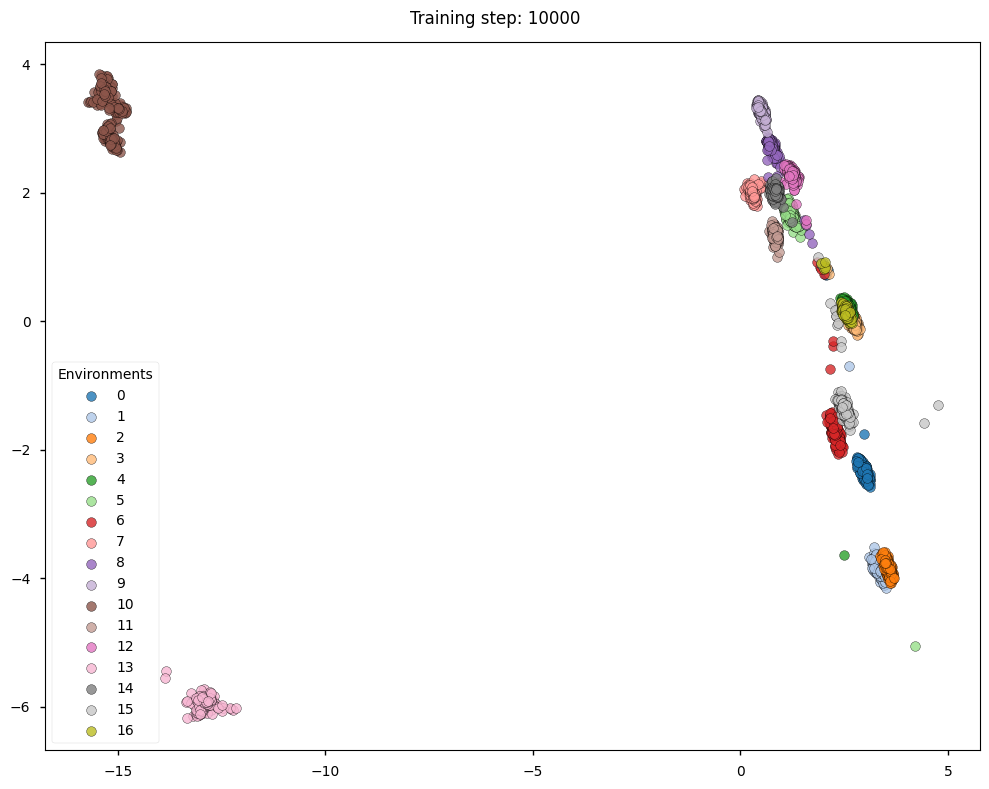

KeyboardInterrupt: 

In [6]:
from IPython.display import clear_output
from sklearn.decomposition import PCA

def context_encoder_loss(agent, batch, grad_params, rng):
    dynamics_embedding_mean, dynamics_embedding_std = agent.select('dynamic_transformer')(batch['observations'], batch['actions'],
                                                                            batch['next_observations'], train=True, params=grad_params)
    dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=rng, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_std)
    dynamics_embedding = jnp.tile(dynamics_embedding[:, None], reps=(1, batch['next_observations'].shape[1], 1))
    next_state_pred = agent.select('next_state_pred')(batch['observations'], batch['actions'], dynamics_embedding, params=grad_params)
    loss = optax.squared_error(next_state_pred, batch['next_observations']).mean()
    return loss, {"context_embedding_loss": loss}

@jax.jit
def update(agent, batch, rng):
    def loss_fn(grad_params):
        # dyn_loss = context_encoder_loss(agent, batch, grad_params)
        return context_encoder_loss(agent, batch, grad_params, rng)
    
    agent, info = agent.apply_loss_fn(loss_fn)
    return agent, info

num_environments = 17
samples_per_env = 200

# Generate colors automatically
env_indices = np.repeat(np.arange(num_environments), samples_per_env)

# Learn transformer
pbar = tqdm(range(30_000))
for update_steps in pbar:
    update_key = jax.random.fold_in(GLOBAL_KEY, i)
    batch = whole_dataset.sample(256)
    network, info = update(network, batch, update_key)
    
    if update_steps % 5_000 == 0:
        clear_output()
        dynamics_embedding_mean, dynamics_embedding_std = network.select('dynamic_transformer')(whole_data['observations'], whole_data['actions'],
                                                                            whole_data['next_observations'], train=False)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=update_key, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_std)
        tsne = PCA(random_state=42).fit_transform(dynamics_embedding)
        fig, ax = plt.subplots(figsize=(10, 8))
        for i in range(num_environments):
            mask = (env_indices == i)
            ax.scatter(tsne[mask, 0], tsne[mask, 1], 
                        color=plt.cm.tab20(i), 
                        edgecolors='black',
                        label=i,
                        alpha=0.8)
            
        fig.suptitle(f"Training step: {update_steps}")   
        ax.legend(title="Environments")
        plt.tight_layout()
        display(fig)
        plt.savefig("antwind.svg", bbox_inches='tight')
        plt.close(fig)
        

In [ ]:
sys.path.append("..")
from agents.fb import ForwardBackwardAgent

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb.yaml'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

try: 
    del whole_data['rewards']
except KeyError:
    pass

whole_data['terminals'] = whole_data['terminals'].reshape(-1)
whole_dataset = Dataset.create(**jax.device_get(jax.tree.map(lambda x: x.reshape(-1, x.shape[-1]) if x.ndim > 2 else x, whole_data)))
print(jax.tree.map(lambda x: x.shape, whole_dataset._dict))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    example_batch['actions'],
    config=fb_config['agent']
)
fb_agent, info = fb_agent.update(gc_whole_dataset.sample(512))

{
│   'seed': 42,
│   'run_group': 'fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 10000,
│   'eval_interval': 200000,
│   'eval_tasks': None,
│   'eval_episodes': 1,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 150,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'f_hidden_dims': [512, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'number_of_meta_envs': 5,
│   │   'use_context': True,
│   │   'warmup_steps': 50000,
│   │   'n_blocks': 2,
│   │   'n_heads': 2,
│   │   'emb_dim': 96,
│   │   'mlp_dim': 512,
│   │   'output_dim': 4,
│   │   'context_len': 100,
│   │   'use_masked_attention': False,
│   │   'use_mean_embedding': True,
│   │   'cosine_schedule': False,
│   │   'w_hidden_dims': [256, 256, 256],
│   │   'world_pred_hidden': [256, 256, 256]
│   },
│   'env': {'env_name': 'gridworld', 'discrete': True},
│   'tags': ['fb', 'discrete']
}

{'actions': (870400, 8), 'next_observations': (870400, 105), 'observations': (870400, 105), 'terminals': (870400,)}


KeyError: 'actor_goals'

In [ ]:
from collections import defaultdict
from utils.evaluation import supply_rng, add_to, flatten
from tqdm import trange

def evaluate_classic(
    agent,
    env,
    config=None,
    num_eval_episodes=50,
    num_video_episodes=0,
    video_frame_skip=3,
    eval_temperature=0,
):
    actor_fn = partial(supply_rng(agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))))
    trajs = []
    stats = defaultdict(list)

    renders = []
    for i in trange(num_eval_episodes + num_video_episodes):
        traj = defaultdict(list)
        should_render = i >= num_eval_episodes

        observation, info = env.reset()
        done = False
        step = 0
        render = []
        while not done:
            action = actor_fn(observations=observation, temperature=eval_temperature)
            action = np.array(action)
            action = np.clip(action, -1, 1)

            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            step += 1

            if should_render and (step % video_frame_skip == 0 or done):
                frame = env.render().copy()
                render.append(frame)

            transition = dict(
                observation=observation,
                next_observation=next_observation,
                actions=action,
                reward=reward,
                done=done,
                info=info,
            )
            add_to(traj, transition)
            observation = next_observation
        if i < num_eval_episodes:
            add_to(stats, flatten(info))
            trajs.append(traj)
        else:
            renders.append(np.array(render))

    for k, v in stats.items():
        stats[k] = np.mean(v)

    return stats, trajs, renders

env = make_online_env("myant-xy", default_ind=0)
ob, info = env.reset()

In [ ]:
selected_keys = ["observation", "next_observation", "actions", "done", "reward"]
test_data = []
for i in range(17, 20):
    cur_data = np.load(f"/home/m_bobrin/ZeroShotRL/envs/mujoco/data_custom_ant/default_ind_{i}.npz", allow_pickle=True)
    data = {key: cur_data[key] for key in selected_keys if key in cur_data.files}
    data['observations'] = data['observation']
    data['next_observations'] = data['next_observation']
    data['rewards'] = data['reward']
    data['terminals'] = data['done'][..., None]
    del data['done']
    del data['observation']
    del data['next_observation']
    del data['reward']
    test_data.append(data)

test_data = functools.reduce(concatenate_dicts, test_data)
test_data = jax.tree.map(lambda x, y: jnp.concatenate([x, y]), whole_data, test_data)

dynamics_embedding_mean, dynamics_embedding_std = network.select('dynamic_transformer')(test_data['observations'], test_data['actions'],
                                                                            test_data['next_observations'], train=False)
dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=update_key, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_std)

num_environments = 20
samples_per_env = 200

# Generate colors automatically
env_indices = np.repeat(np.arange(num_environments), samples_per_env)

tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(20):
    mask = (env_indices == i)
    ax.scatter(tsne[mask, 0], tsne[mask, 1], 
                color=plt.cm.tab20(i), 
                edgecolors='black',
                label=i,
                alpha=0.8)
    ax.legend()
plt.savefig("antwind.svg", bbox_inches='tight', dpi=300)

NameError: name 'np' is not defined